In [2]:
from mftool import Mftool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yahooquery import Ticker
import datetime
from dateutil.relativedelta import relativedelta
from jugaad_data.nse import index_raw

%matplotlib inline

In [3]:
def fetch_index_data(index, start_date='1-1-2019', end_date='31-12-2023'):
    
    def convert_to_date(date_str):
        date_obj = datetime.datetime.strptime(date_str, '%d %b %Y')
        return date_obj

    # Get from and to dates
    from_date = datetime.datetime.strptime(start_date, '%d-%m-%Y').date()
    to_date = datetime.datetime.strptime(end_date, '%d-%m-%Y').date()
    
    # Pull data
    raw_index_data = index_raw(symbol=index, from_date=from_date, to_date=to_date)
    df = (pd.DataFrame(raw_index_data)\
            .assign(HistoricalDate=lambda x: x['HistoricalDate'].apply(convert_to_date),
                    CLOSE=lambda x: x['CLOSE'].astype(float),
                    INDEX_NAME = lambda x: x['INDEX_NAME'].str.upper())\
            .sort_values('HistoricalDate')\
            .drop_duplicates()\
            .loc[lambda x: x['INDEX_NAME'] == index]\
            .reset_index(drop=True)\
            .rename(columns={'HistoricalDate':'date'})
                       )
    df = df.loc[~df.duplicated(subset=['date'], keep='first')]
    return df


In [4]:
def fetch_mutual_fund_data(mutual_fund_code):
    mf = Mftool()
    
    df = (mf.get_scheme_historical_nav(mutual_fund_code,as_Dataframe=True).reset_index()\
          .assign(nav=lambda x: x['nav'].astype(float), 
                 date=lambda x: pd.to_datetime(x['date'], format='%d-%m-%Y'))\
          .sort_values('date')\
          .reset_index(drop=True)\
         )
    
    return df

In [5]:
def get_cumulative_returns(df, 
                         nav_col='CLOSE', 
                         date_col='date',
                         starting_date='1-1-2019', 
                         ending_date ='31-12-2023'):
    start_date = pd.to_datetime(starting_date, format='%d-%m-%Y')
    end_date = pd.to_datetime(ending_date, format='%d-%m-%Y')
    
    df = (df\
          .sort_values(date_col)\
          .query(f"{date_col} >= @start_date and {date_col} <=@end_date")\
          .assign(daily_returns=lambda x: x[nav_col].pct_change(),
                  cumulative_daily_returns=lambda x: (x['daily_returns'] + 1).cumprod())\
          .reset_index(drop=True)\
         )
    
    return df

### Pull Nifty Data

In [6]:
nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200", "NIFTY 100"]
nifty_indices_df_dict = {index: fetch_index_data(index) for index in nifty_indices}

### Pull Mutual Funds Data

In [7]:
# Fetch data for these funds
mutual_funds = {'120819': 'quant Absolute Fund-Growth Option-Direct Plan',
 '120828': 'quant Small Cap Fund - Growth Option - Direct Plan',
 '119063': 'HDFC Index Fund-NIFTY 50 Plan - Direct Plan',
 '118955': 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 '118269': 'CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION',
 '122639': 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
 '125307': 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option', 
 '146271': 'Nippon India ETF Nifty Midcap 150', 
 '147704': 'Motilal Oswal Large and Midcap Fund - Direct Plan Growth',
}

mf_data_dict = dict()
for mutual_fund_code, mutual_fund_desc in mutual_funds.items():
    print(mutual_fund_desc)
    mf_data_dict[mutual_fund_desc] = fetch_mutual_fund_data(mutual_fund_code)

quant Absolute Fund-Growth Option-Direct Plan
quant Small Cap Fund - Growth Option - Direct Plan
HDFC Index Fund-NIFTY 50 Plan - Direct Plan
HDFC Flexi Cap Fund - Growth Option - Direct Plan
CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION
Parag Parikh Flexi Cap Fund - Direct Plan - Growth
PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option
Nippon India ETF Nifty Midcap 150
Motilal Oswal Large and Midcap Fund - Direct Plan Growth


### Calculate cumulative returns and growth %

In [8]:
time_periods = {
    1: '1-1-2023', 
    2: '1-1-2022', 
    3: '1-1-2021',
    4: '1-1-2020',
    5: '1-1-2019',
}
results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}

# Mutual Funds data
mutual_funds_subset = ['quant Absolute Fund-Growth Option-Direct Plan',
 'quant Small Cap Fund - Growth Option - Direct Plan',
 'HDFC Index Fund-NIFTY 50 Plan - Direct Plan',
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 'CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION',
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option',
 'Nippon India ETF Nifty Midcap 150',
 'Motilal Oswal Large and Midcap Fund - Direct Plan Growth']

for instrument_desc in mutual_funds_subset: 
    for time_period, starting_date in time_periods.items():
        n_years = time_period
        mutual_fund_data = mf_data_dict[instrument_desc].copy(deep=True)
        mf_with_cumulative = get_cumulative_returns(mutual_fund_data, 
                                                           nav_col='nav', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date ='31-12-2023')
        absolute_returns_prcnt = (mf_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((mf_with_cumulative['nav'].iloc[-1]/mf_with_cumulative['nav'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_dataframes[time_period][instrument_desc] = mf_with_cumulative
        results += [(instrument_desc, time_period, absolute_returns_prcnt, cagr)]
        

## Indices cumulative returns and growth 
nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200", "NIFTY 100"]
nifty_indices_results = []
time_period_nifty_dataframes = {time_period: dict() for time_period in time_periods}


for index in nifty_indices:
    print(index)
    for time_period, starting_date in time_periods.items():
        n_years = time_period
        index_df = nifty_indices_df_dict[index].copy(deep=True)
        index_with_cumulative = get_cumulative_returns(index_df, 
                                                           nav_col='CLOSE', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date ='31-12-2023')
        absolute_returns_prcnt = (index_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((index_with_cumulative['CLOSE'].iloc[-1]/index_with_cumulative['CLOSE'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_nifty_dataframes[time_period][index] = index_with_cumulative
        nifty_indices_results += [(index, time_period, absolute_returns_prcnt, cagr)]

NIFTY 500
NIFTY 50
NIFTY MIDCAP 150
NIFTY SMALLCAP 250
NIFTY 200
NIFTY 100


### Calculate returns or abs growth for each year 

In [9]:
time_periods = {
    2023: ('1-1-2023', '31-12-2023'), 
    2022: ('1-1-2022', '31-12-2022'),
    2021: ('1-1-2021', '31-12-2021'),
    2020: ('1-1-2020', '31-12-2020'),
    2019: ('1-1-2019', '31-12-2019'),
}

mf_results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}

# Mutual Funds data
mutual_funds_subset = ['quant Absolute Fund-Growth Option-Direct Plan',
 'quant Small Cap Fund - Growth Option - Direct Plan',
 'HDFC Index Fund-NIFTY 50 Plan - Direct Plan',
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 'CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION',
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option',
 'Nippon India ETF Nifty Midcap 150',
 'Motilal Oswal Large and Midcap Fund - Direct Plan Growth']

for instrument_desc in mutual_funds_subset: 
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        mutual_fund_data = mf_data_dict[instrument_desc].copy(deep=True)
        mf_with_cumulative = get_cumulative_returns(mutual_fund_data, 
                                                           nav_col='nav', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date =ending_date)
        absolute_returns_prcnt = (mf_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100

        time_period_dataframes[time_period][instrument_desc] = mf_with_cumulative
        mf_results += [(instrument_desc, time_period, absolute_returns_prcnt)]
        

## Indices cumulative returns and growth 
nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200", "NIFTY 100"]
nifty_indices_results = []
time_period_nifty_dataframes = {time_period: dict() for time_period in time_periods}


for index in nifty_indices:
    print(index)
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        index_df = nifty_indices_df_dict[index].copy(deep=True)
        index_with_cumulative = get_cumulative_returns(index_df, 
                                                           nav_col='CLOSE', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date=ending_date)
        absolute_returns_prcnt = (index_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100

        time_period_nifty_dataframes[time_period][index] = index_with_cumulative
        nifty_indices_results += [(index, time_period, absolute_returns_prcnt)]

NIFTY 500
NIFTY 50
NIFTY MIDCAP 150
NIFTY SMALLCAP 250
NIFTY 200
NIFTY 100


In [10]:
mf_result_df = pd.DataFrame(mf_results, columns=['Fund', 'Years', 'Abs_returns_prcnt',]).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt',])
mf_result_df.columns = [f'{x}_{y}' for x, y in mf_result_df.columns]
mf_result_df = mf_result_df.applymap(lambda x: f"{x:.2f}%").reset_index()
mf_result_df

,Fund,Abs_returns_prcnt_2019,Abs_returns_prcnt_2020,Abs_returns_prcnt_2021,Abs_returns_prcnt_2022,Abs_returns_prcnt_2023
0,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,16.83%,24.55%,26.17%,0.82%,23.19%
1,HDFC Flexi Cap Fund - Growth Option - Direct Plan,6.68%,6.61%,36.17%,17.29%,30.67%
2,HDFC Index Fund-NIFTY 50 Plan - Direct Plan,12.70%,15.20%,24.91%,3.77%,20.41%
3,Motilal Oswal Large and Midcap Fund - Direct P...,5.02%,14.33%,42.31%,1.90%,39.75%
4,Nippon India ETF Nifty Midcap 150,4.19%,24.90%,45.93%,2.47%,43.27%
5,PGIM India Midcap Opportunities Fund - Direct ...,4.85%,51.13%,65.12%,-0.81%,21.68%
6,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,14.93%,33.28%,46.76%,-6.51%,37.49%
7,quant Absolute Fund-Growth Option-Direct Plan,6.93%,37.21%,43.74%,13.93%,16.76%
8,quant Small Cap Fund - Growth Option - Direct ...,-23.43%,74.95%,89.90%,9.17%,45.56%


In [11]:
nifty_result_df = pd.DataFrame(nifty_indices_results, columns=['Fund', 'Years', 'Abs_returns_prcnt']).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt'])
nifty_result_df.columns = [f'{x}_{y}' for x, y in nifty_result_df.columns]
nifty_result_df = nifty_result_df.applymap(lambda x: f"{x:.2f}%").reset_index()
nifty_result_df

,Fund,Abs_returns_prcnt_2019,Abs_returns_prcnt_2020,Abs_returns_prcnt_2021,Abs_returns_prcnt_2022,Abs_returns_prcnt_2023
0,NIFTY 100,10.04%,14.75%,24.62%,2.15%,19.55%
1,NIFTY 200,8.34%,15.49%,26.92%,2.21%,22.91%
2,NIFTY 50,11.53%,14.77%,23.79%,2.72%,19.42%
3,NIFTY 500,7.33%,16.48%,29.56%,1.61%,25.16%
4,NIFTY MIDCAP 150,-0.32%,23.94%,45.14%,1.82%,42.66%
5,NIFTY SMALLCAP 250,-8.60%,24.19%,60.10%,-4.87%,46.99%


### Mapping funds to their benchmarks

In [12]:
nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200"]

funds_benchmark_mapping = {'quant Absolute Fund-Growth Option-Direct Plan': "NIFTY 500",
 'quant Small Cap Fund - Growth Option - Direct Plan': "NIFTY SMALLCAP 250",
 'HDFC Index Fund-NIFTY 50 Plan - Direct Plan': "NIFTY 50",
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan': "NIFTY 500",
 'CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION': "NIFTY 100",
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth': "NIFTY 500",
 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option': "NIFTY MIDCAP 150",
 'Nippon India ETF Nifty Midcap 150': "NIFTY MIDCAP 150",
 'Motilal Oswal Large and Midcap Fund - Direct Plan Growth': "NIFTY 200"}

In [13]:
mapping_df = pd.DataFrame(list(funds_benchmark_mapping.items()), columns=['Fund', 'Index'])
mapping_df

,Fund,Index
0,quant Absolute Fund-Growth Option-Direct Plan,NIFTY 500
1,quant Small Cap Fund - Growth Option - Direct ...,NIFTY SMALLCAP 250
2,HDFC Index Fund-NIFTY 50 Plan - Direct Plan,NIFTY 50
3,HDFC Flexi Cap Fund - Growth Option - Direct Plan,NIFTY 500
4,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,NIFTY 100
5,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,NIFTY 500
6,PGIM India Midcap Opportunities Fund - Direct ...,NIFTY MIDCAP 150
7,Nippon India ETF Nifty Midcap 150,NIFTY MIDCAP 150
8,Motilal Oswal Large and Midcap Fund - Direct P...,NIFTY 200


### Yearly returns comparison - funds vs benchmark

The returns are calculated at a yearly basis

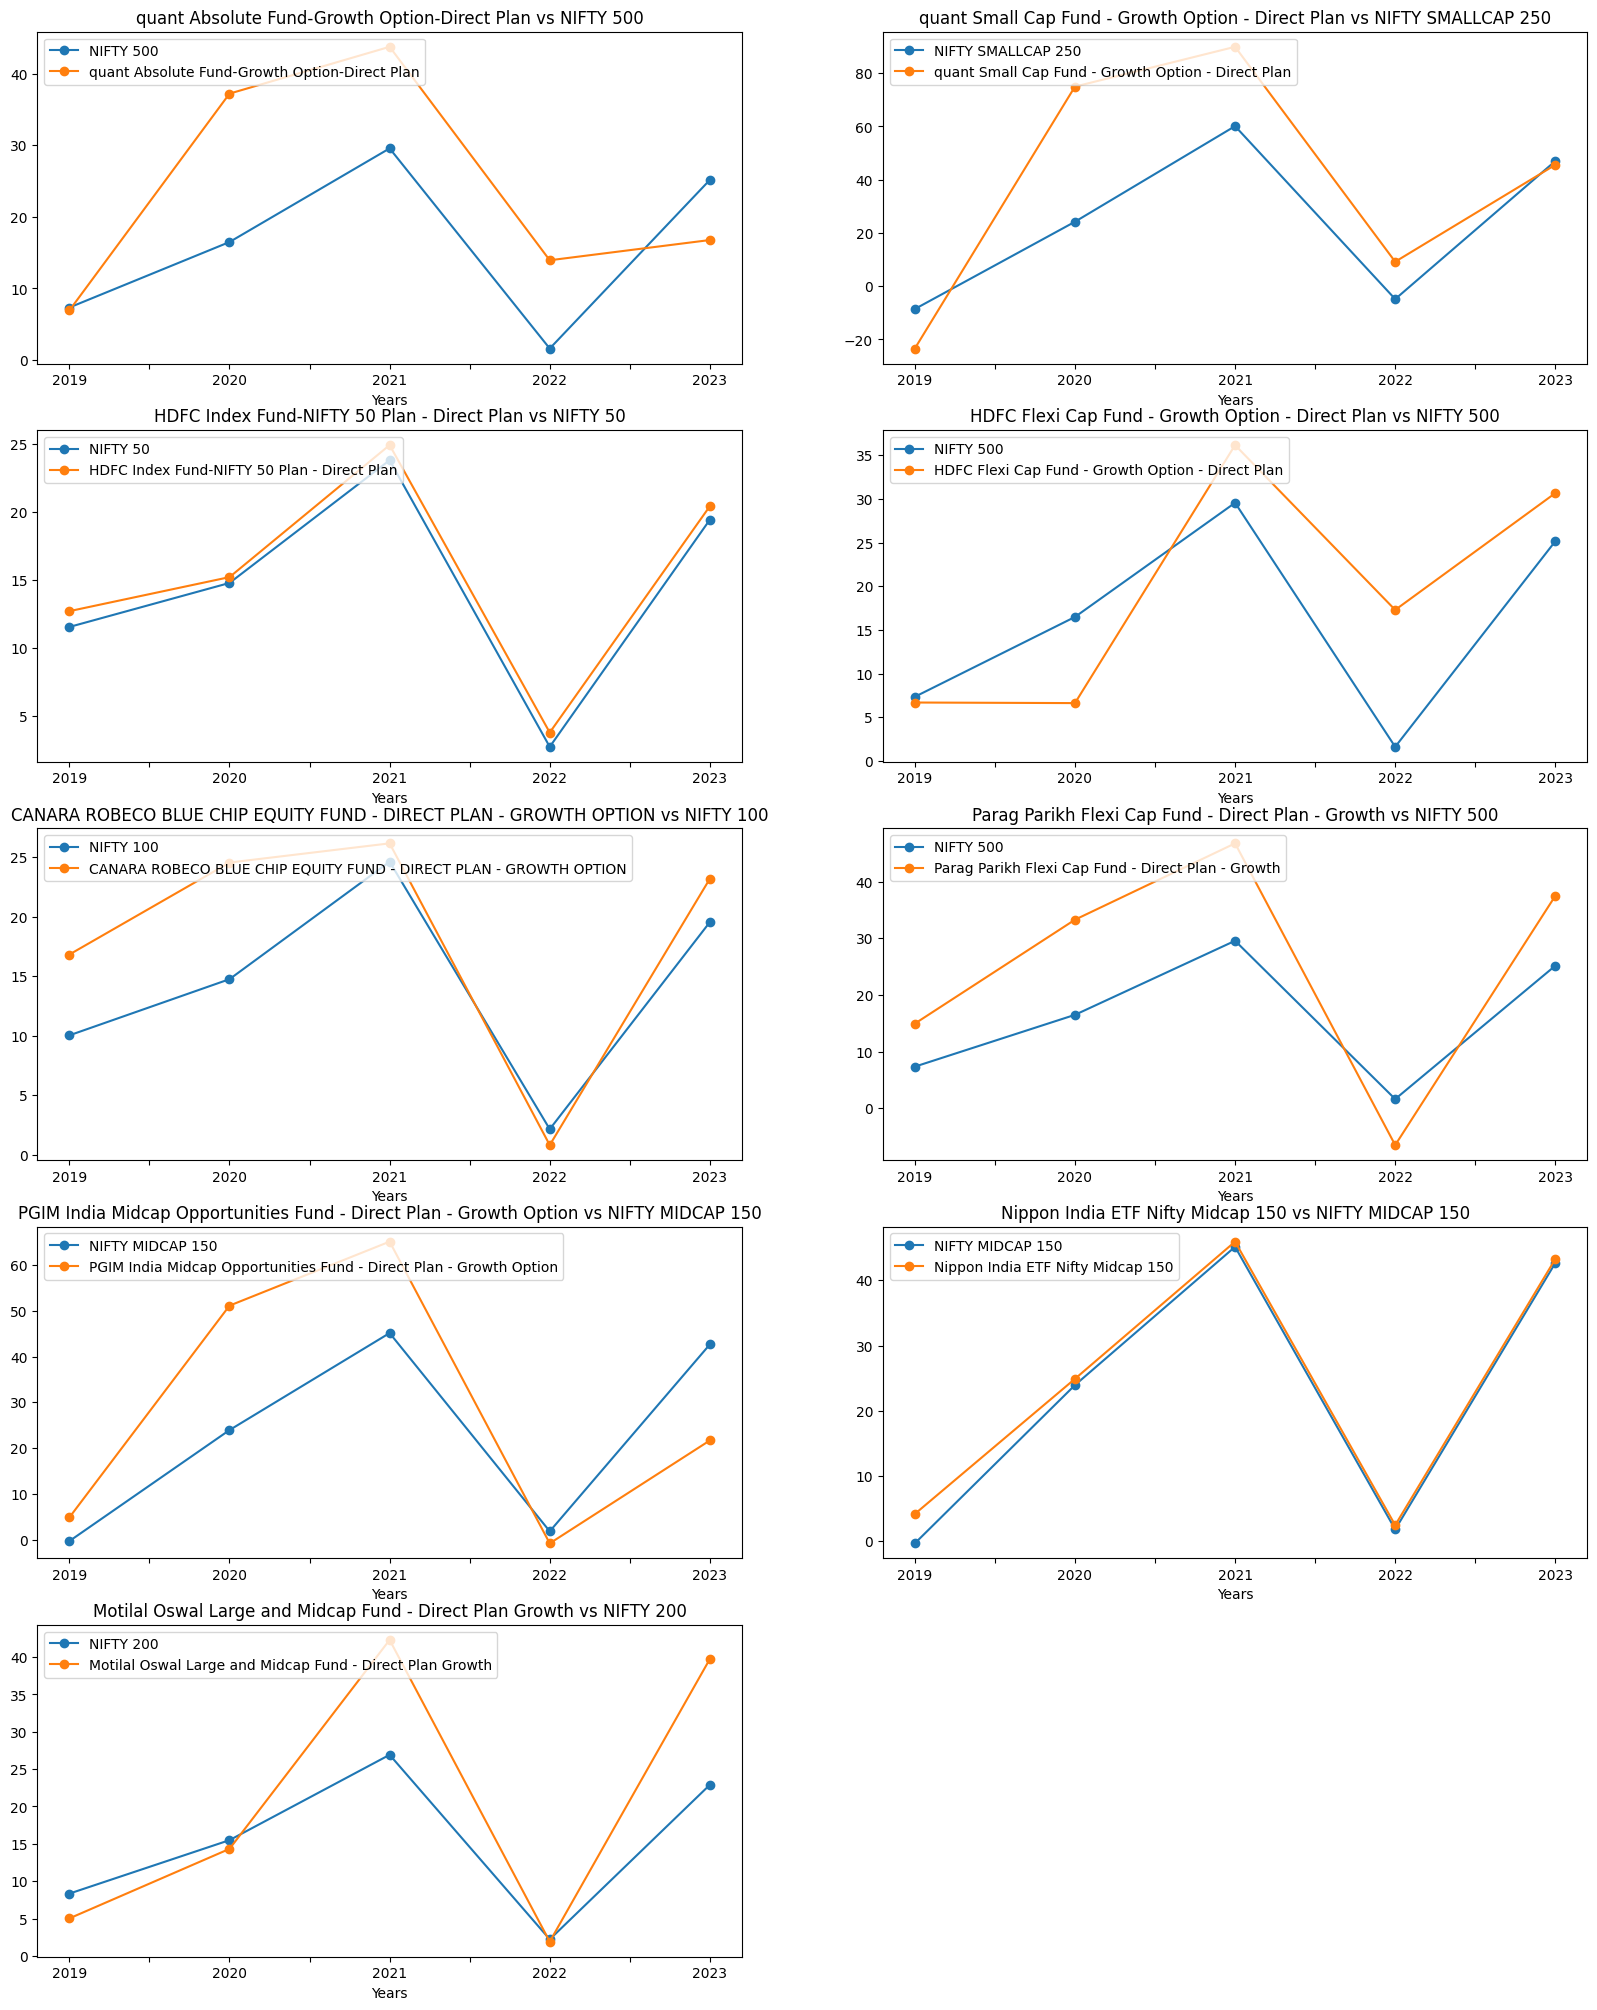

In [28]:
nifty_results_long = pd.DataFrame(nifty_indices_results, columns=['Index', 'Years', 'Abs_returns_prcnt'])
funds_results_long = pd.DataFrame(mf_results, columns=['Fund', 'Years', 'Abs_returns_prcnt',])
plt.rcParams["figure.figsize"] = [4,3]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))

# Flatten the axes array for easy indexing and set it off initially
axes = axes.flatten()
for ax in axes:
    ax.set_axis_off()


def df_process(df):
    df = df.sort_values('Years')
    df['Years'] = df['Years'].astype(str)
    return df

for idx, (fund, index) in enumerate(funds_benchmark_mapping.items()):
    index_df = nifty_results_long.loc[nifty_results_long['Index'] == index].copy()
    fund_df = funds_results_long.loc[funds_results_long['Fund'] == fund].copy()
    
    index_df = df_process(index_df)
    fund_df = df_process(fund_df)

    ax = axes[idx]
    index_df.plot(ax=ax, y='Abs_returns_prcnt', x='Years', label=index, marker='o',)
    fund_df.plot(ax = ax, y='Abs_returns_prcnt', x='Years', label=fund, marker='o',)
    ax.legend(loc='upper left')
    ax.set_title(f'{fund} vs {index}')
    ax.set_axis_on()
    
plt.show()

### How many years has the fund outperformed the benchmark?

In [41]:
fund_benchmark_yr_lvl = funds_results_long.merge(mapping_df, on='Fund').\
                                        merge(nifty_results_long, on=['Index', 'Years'], suffixes=['_fund', '_index'])
fund_benchmark_yr_lvl['outperform_index'] = np.where(fund_benchmark_yr_lvl['Abs_returns_prcnt_fund'] >= fund_benchmark_yr_lvl['Abs_returns_prcnt_index'], 
                                                           1, 0)
fund_benchmark_yr_lvl.sort_values(['Fund', 'Years'])

,Fund,Years,Abs_returns_prcnt_fund,Index,Abs_returns_prcnt_index,outperform_index
29,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,2019,16.827309,NIFTY 100,10.036506,1
28,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,2020,24.554184,NIFTY 100,14.754399,1
27,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,2021,26.166941,NIFTY 100,24.624139,1
26,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,2022,0.815101,NIFTY 100,2.152568,0
25,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,2023,23.194239,NIFTY 100,19.550787,1
13,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2019,6.679891,NIFTY 500,7.334826,0
10,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2020,6.613401,NIFTY 500,16.481183,0
7,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2021,36.170054,NIFTY 500,29.558482,1
4,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2022,17.287922,NIFTY 500,1.606422,1
1,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2023,30.669438,NIFTY 500,25.158387,1


In [39]:
fund_benchmark_yr_lvl.groupby(['Fund', 'Index']).agg({'outperform_index': ['sum', 'count']})

outperform_index  \
                                                                                   sum   
Fund                                               Index                                 
CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PL... NIFTY 100                         4   
HDFC Flexi Cap Fund - Growth Option - Direct Plan  NIFTY 500                         3   
HDFC Index Fund-NIFTY 50 Plan - Direct Plan        NIFTY 50                          5   
Motilal Oswal Large and Midcap Fund - Direct Pl... NIFTY 200                         2   
Nippon India ETF Nifty Midcap 150                  NIFTY MIDCAP 150                  5   
PGIM India Midcap Opportunities Fund - Direct P... NIFTY MIDCAP 150                  3   
Parag Parikh Flexi Cap Fund - Direct Plan - Growth NIFTY 500                         4   
quant Absolute Fund-Growth Option-Direct Plan      NIFTY 500                         3   
quant Small Cap Fund - Growth Option - Direct Plan NIFTY SMALLCAP 250                3   

                                                                             
                                                                      count  
Fund                                               Index                     
CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PL... NIFTY 100              5  
HDFC Flexi Cap Fund - Growth Option - Direct Plan  NIFTY 500              5  
HDFC Index Fund-NIFTY 50 Plan - Direct Plan        NIFTY 50               5  
Motilal Oswal Large and Midcap Fund - Direct Pl... NIFTY 200              5  
Nippon India ETF Nifty Midcap 150                  NIFTY MIDCAP 150       5  
PGIM India Midcap Opportunities Fund - Direct P... NIFTY MIDCAP 150       5  
Parag Parikh Flexi Cap Fund - Direct Plan - Growth NIFTY 500              5  
quant Absolute Fund-Growth Option-Direct Plan      NIFTY 500              5  
quant Small Cap Fund - Growth Option - Direct Plan NIFTY SMALLCAP 250     5

Now that we know the funds performed against their respective benchmark each year, what impact does it have on the CAGR and the absolute returns? 
Say a fund beat benchmark 3/5 times and another fund beat the benchmark 4/5, does that mean the 2nd fund is superior? Need to look at CAGR/cumulative returns as well as the volatility measures. 

### Plotting funds vs benchmarks - Only 1 time period

These graphs are a deep-dive of the above yearly numbers. Shows how the values perform throughout a year and not just a single number

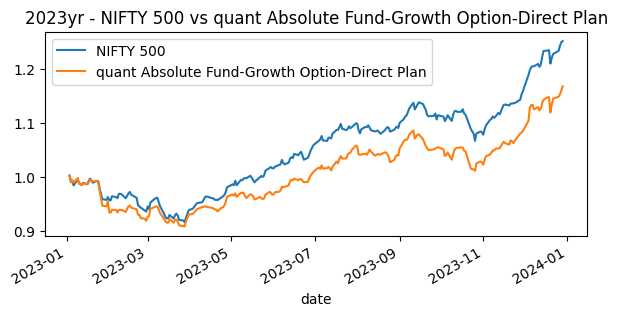

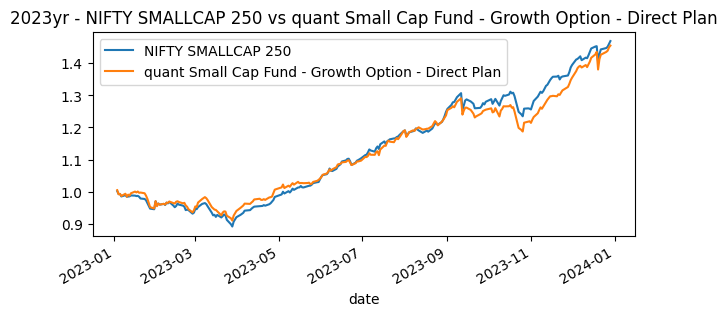

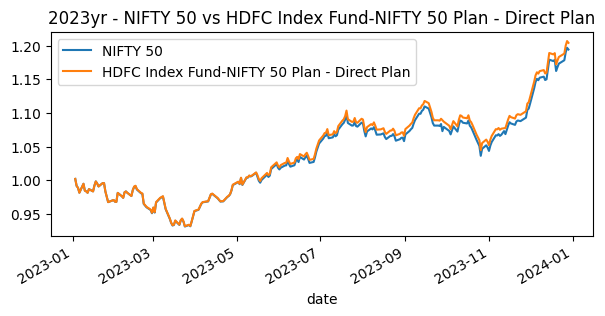

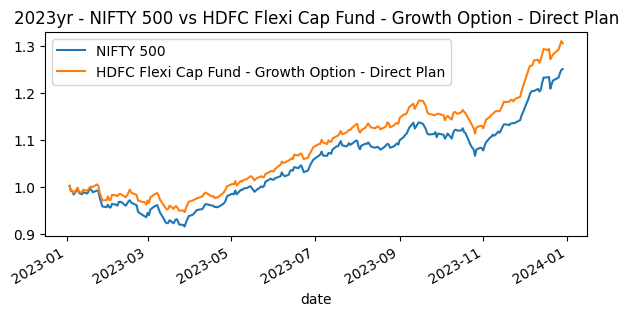

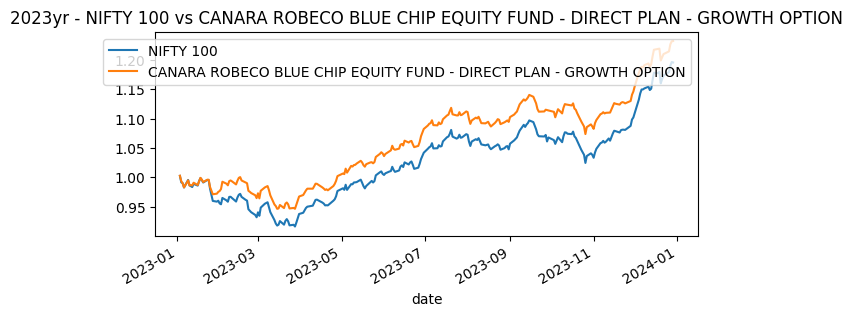

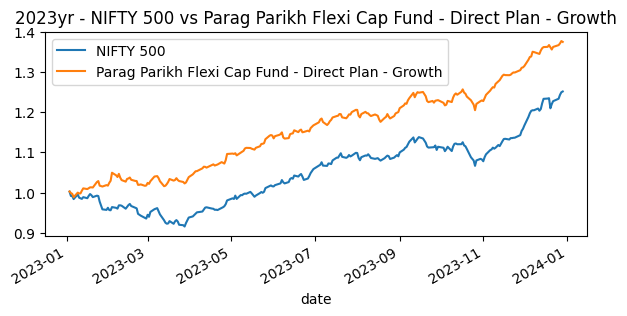

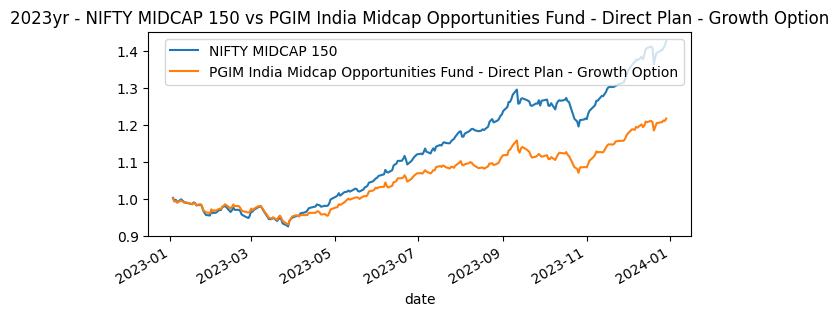

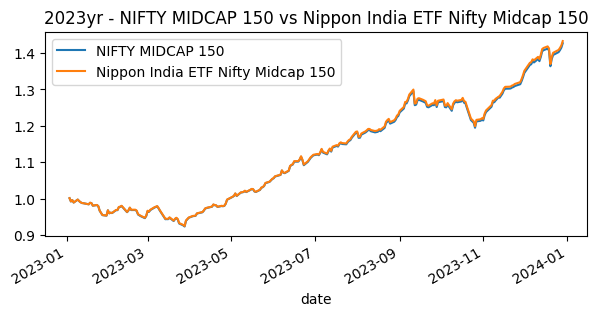

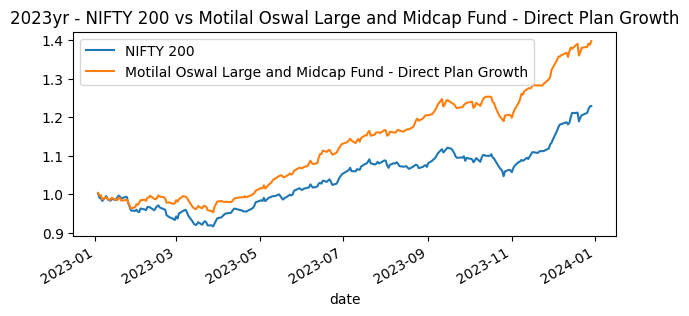

In [20]:
plt.rcParams["figure.figsize"] = [7,3]
time_period = 2023
for fund, index in funds_benchmark_mapping.items():
    index_df = time_period_nifty_dataframes[time_period][index].copy()
    fund_df = time_period_dataframes[time_period][fund].copy()

    ax = index_df.plot(y='cumulative_daily_returns', x='date', label=index)
    fund_df.plot(ax = ax, y='cumulative_daily_returns', x='date', label=fund)
    plt.title(f'{time_period}yr - {index} vs {fund}')
    plt.show()


###  Plotting funds vs benchmarks -Multiple time period subplots

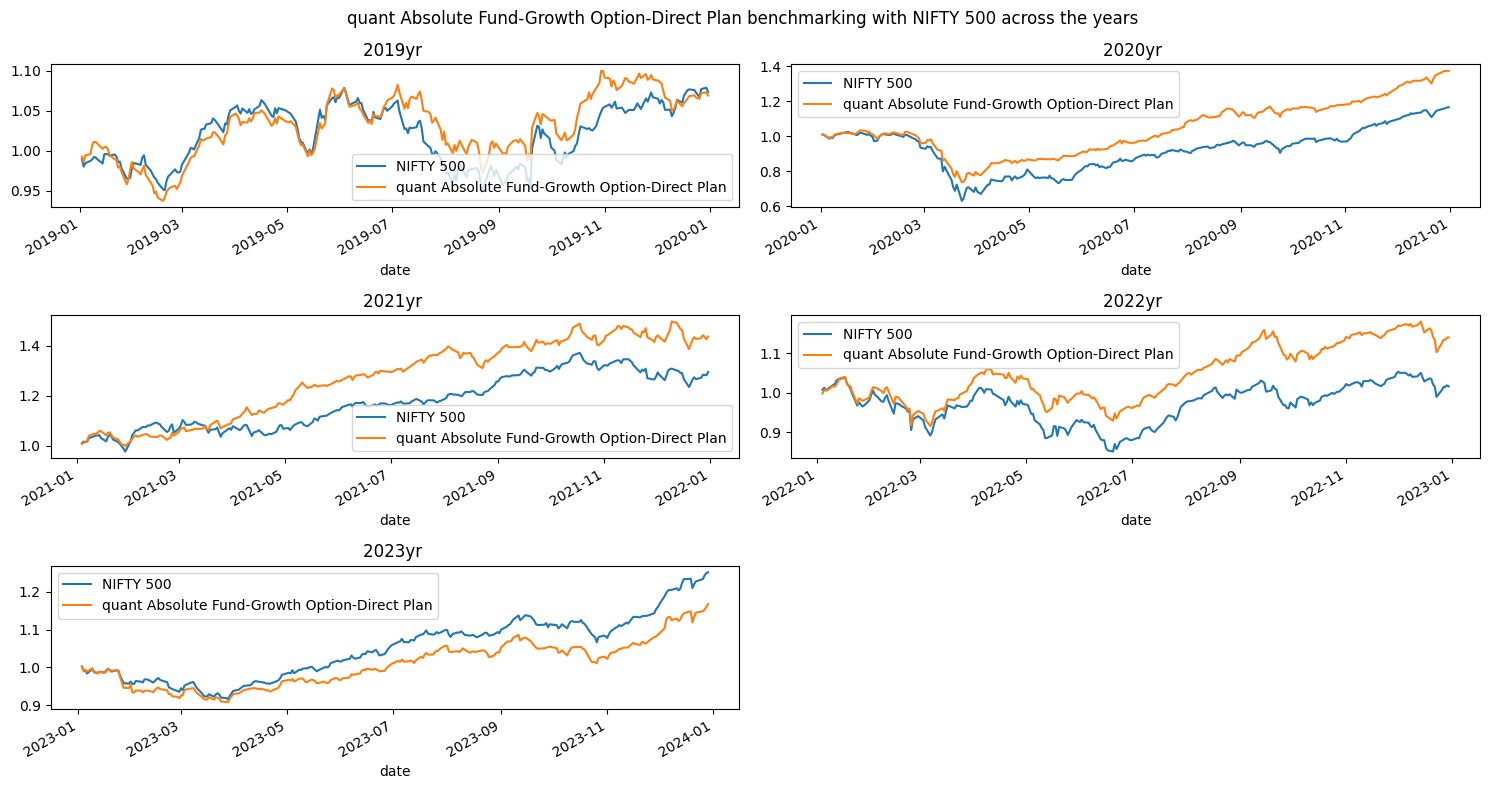

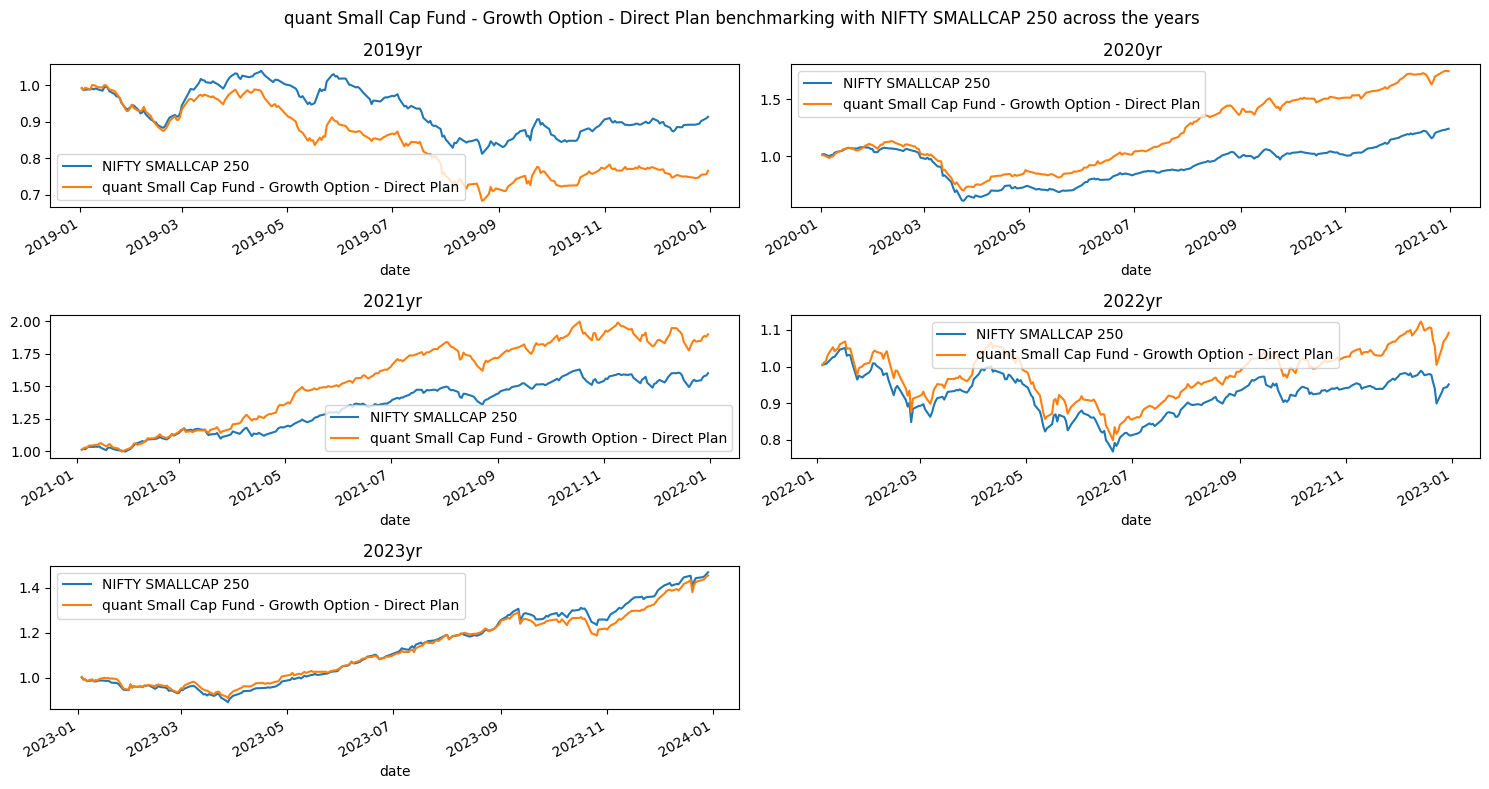

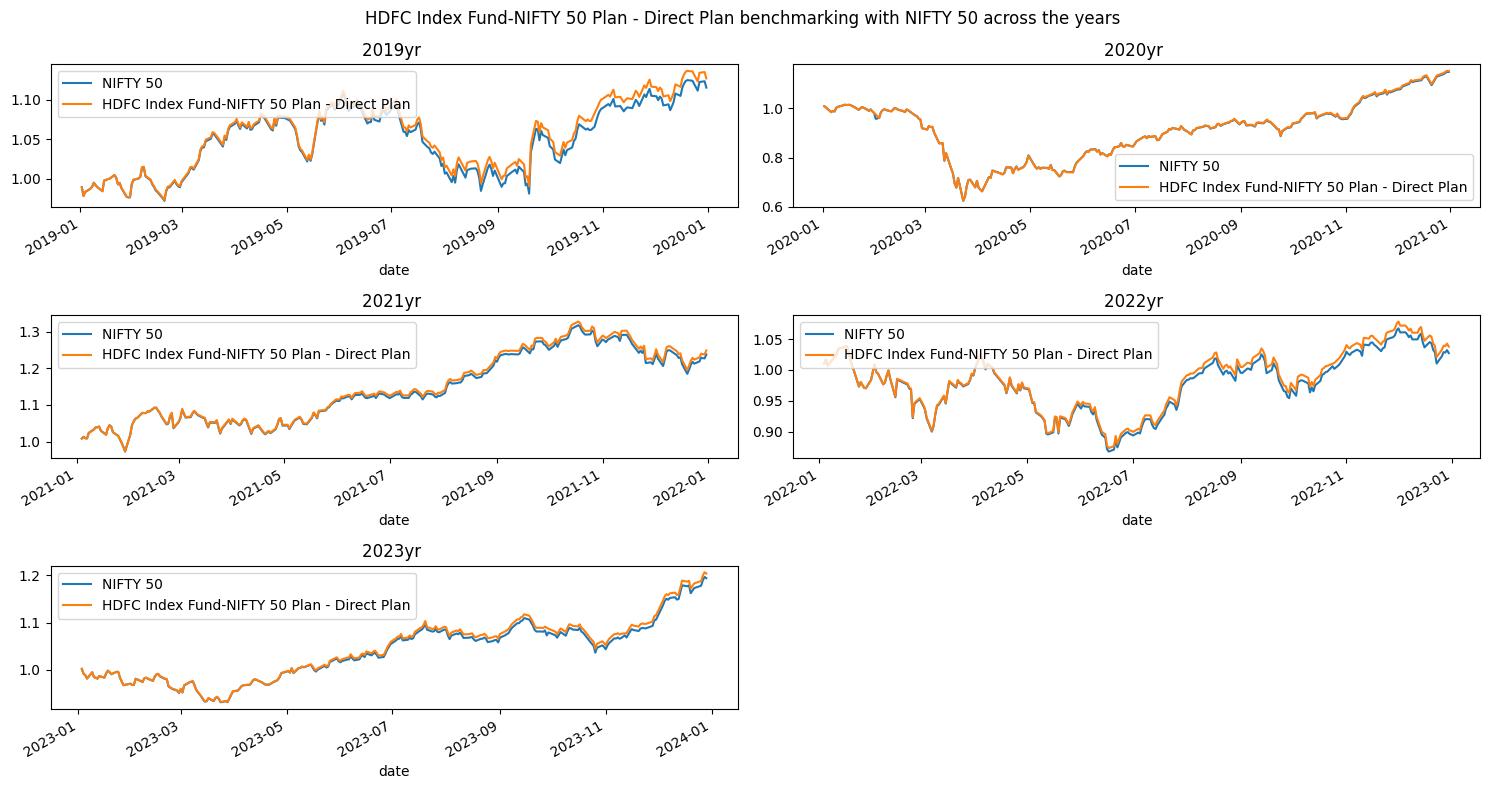

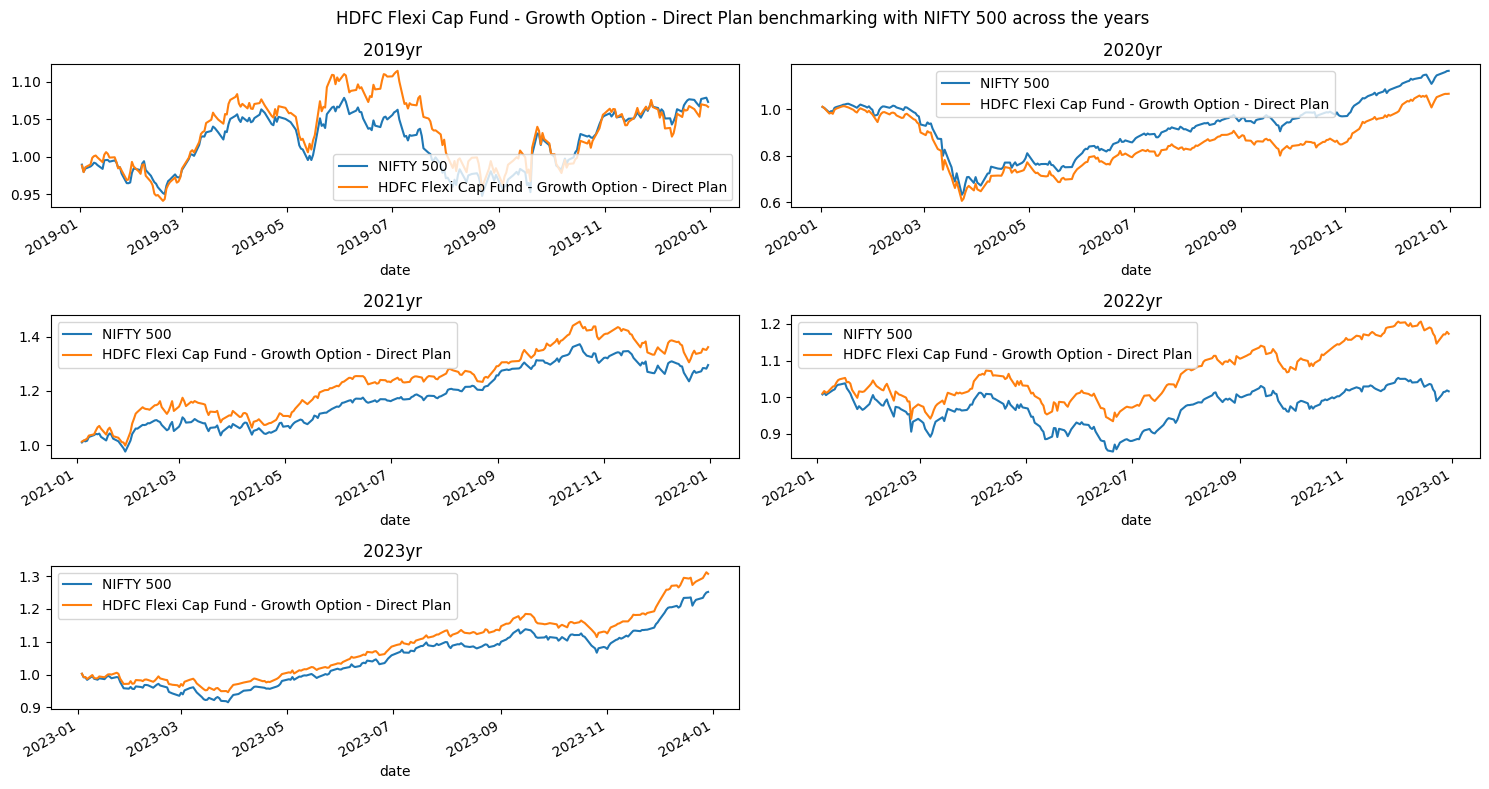

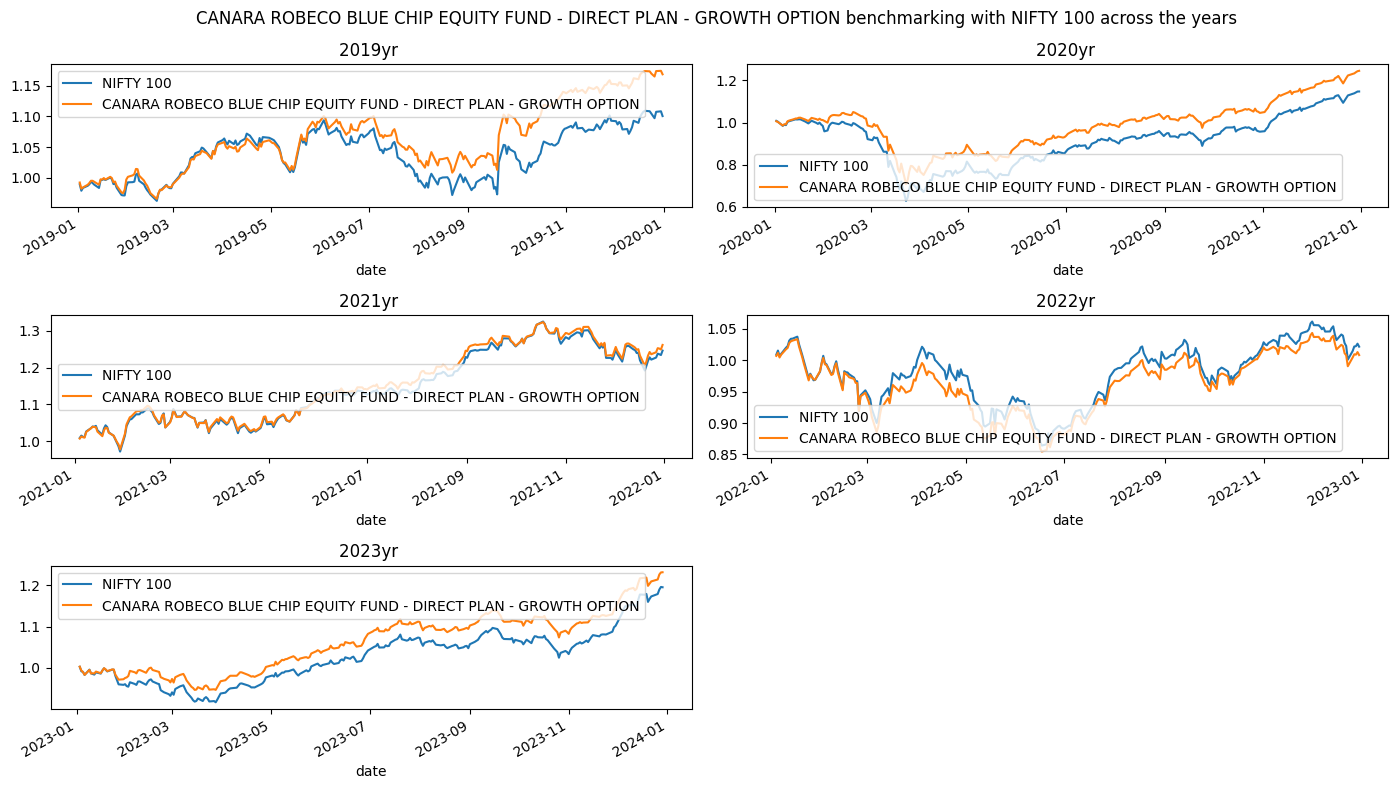

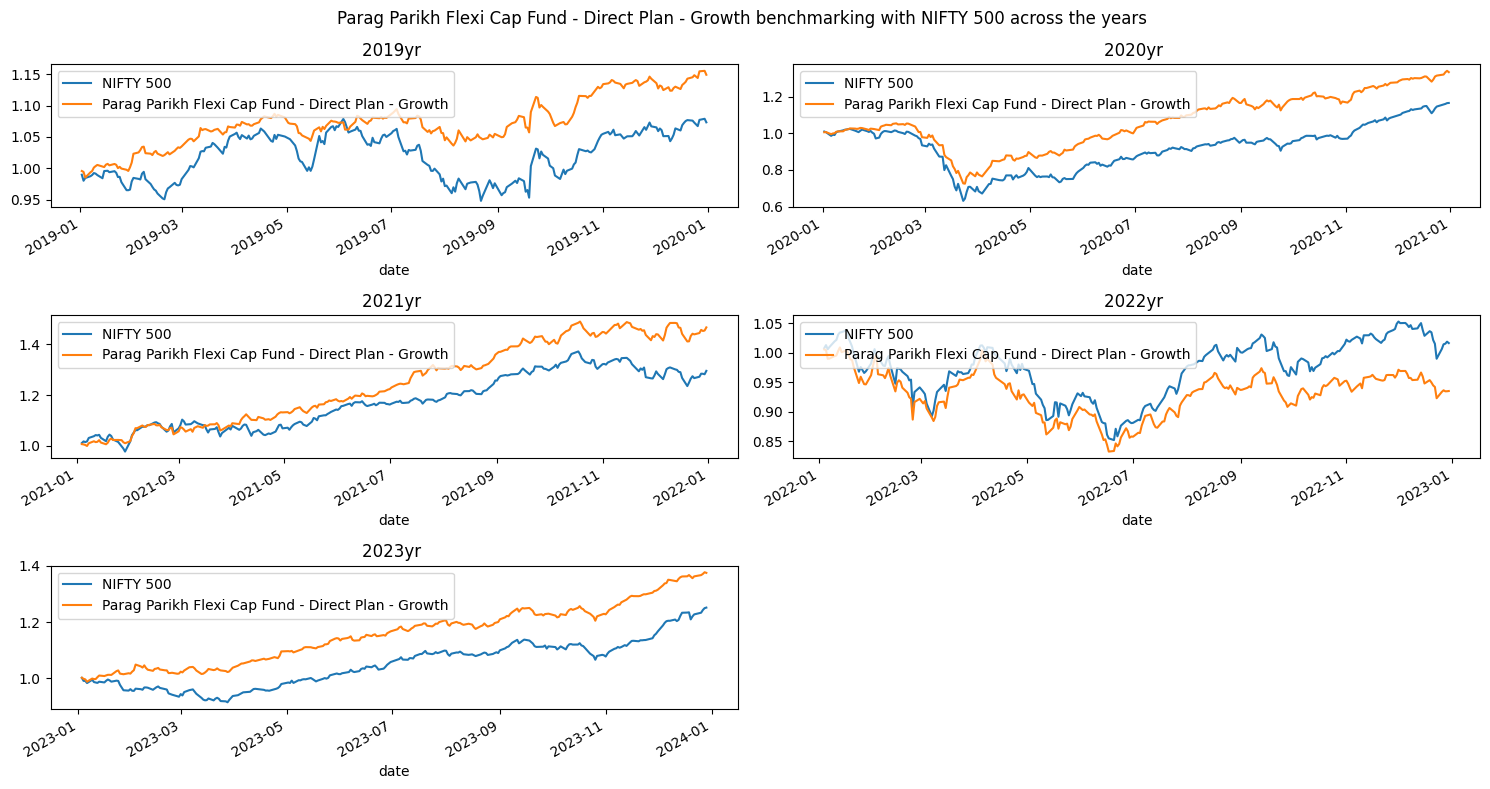

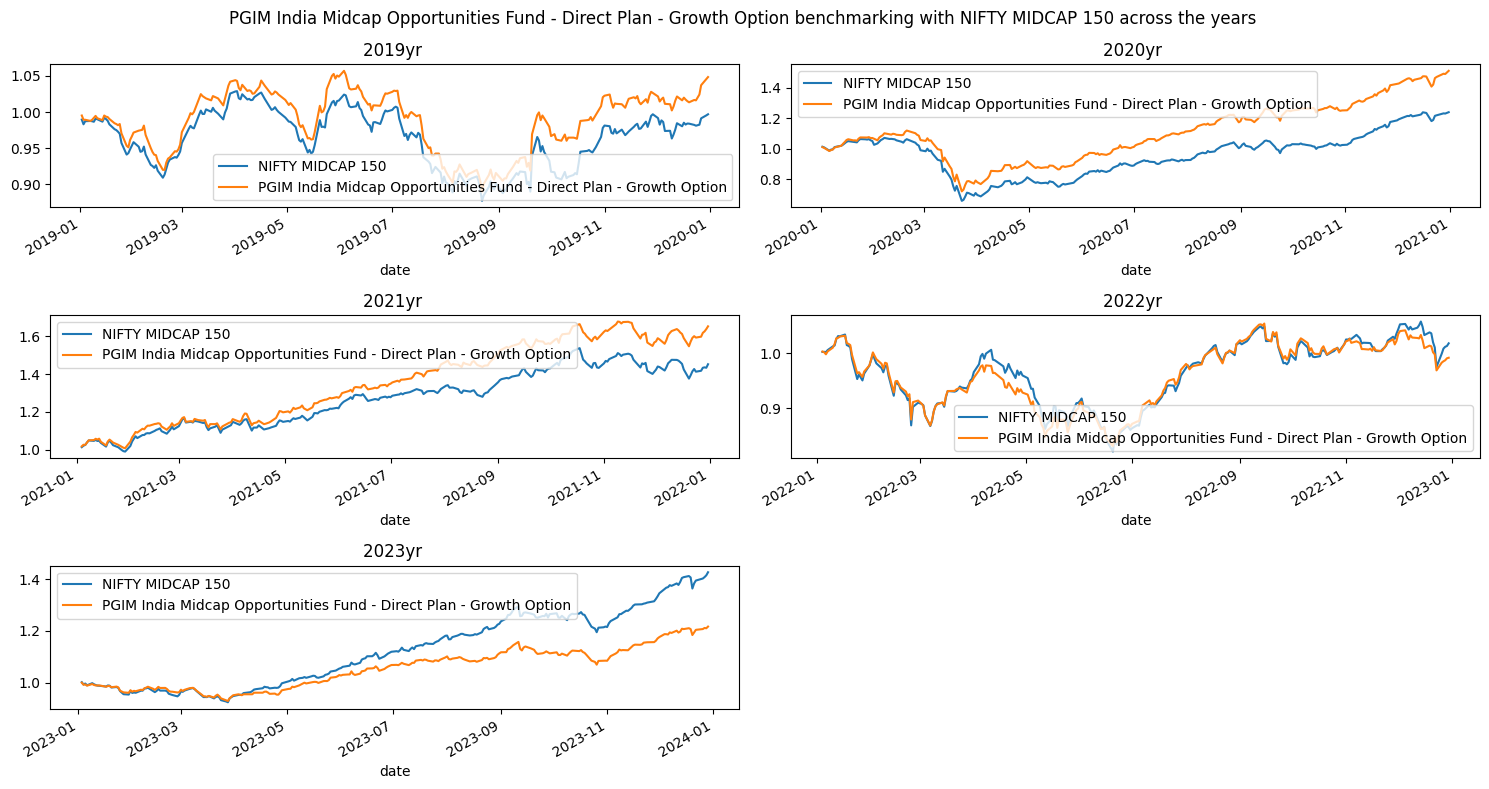

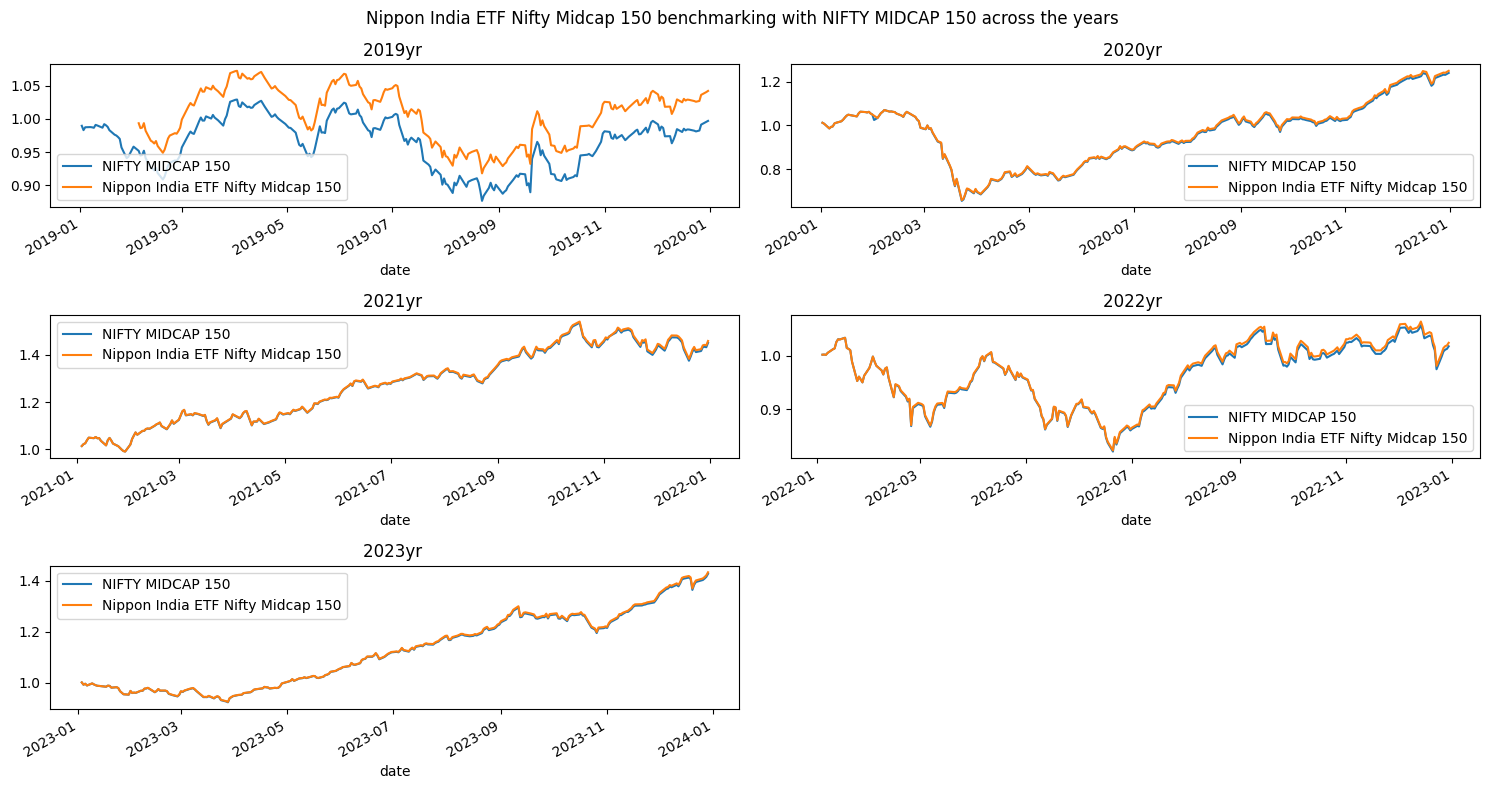

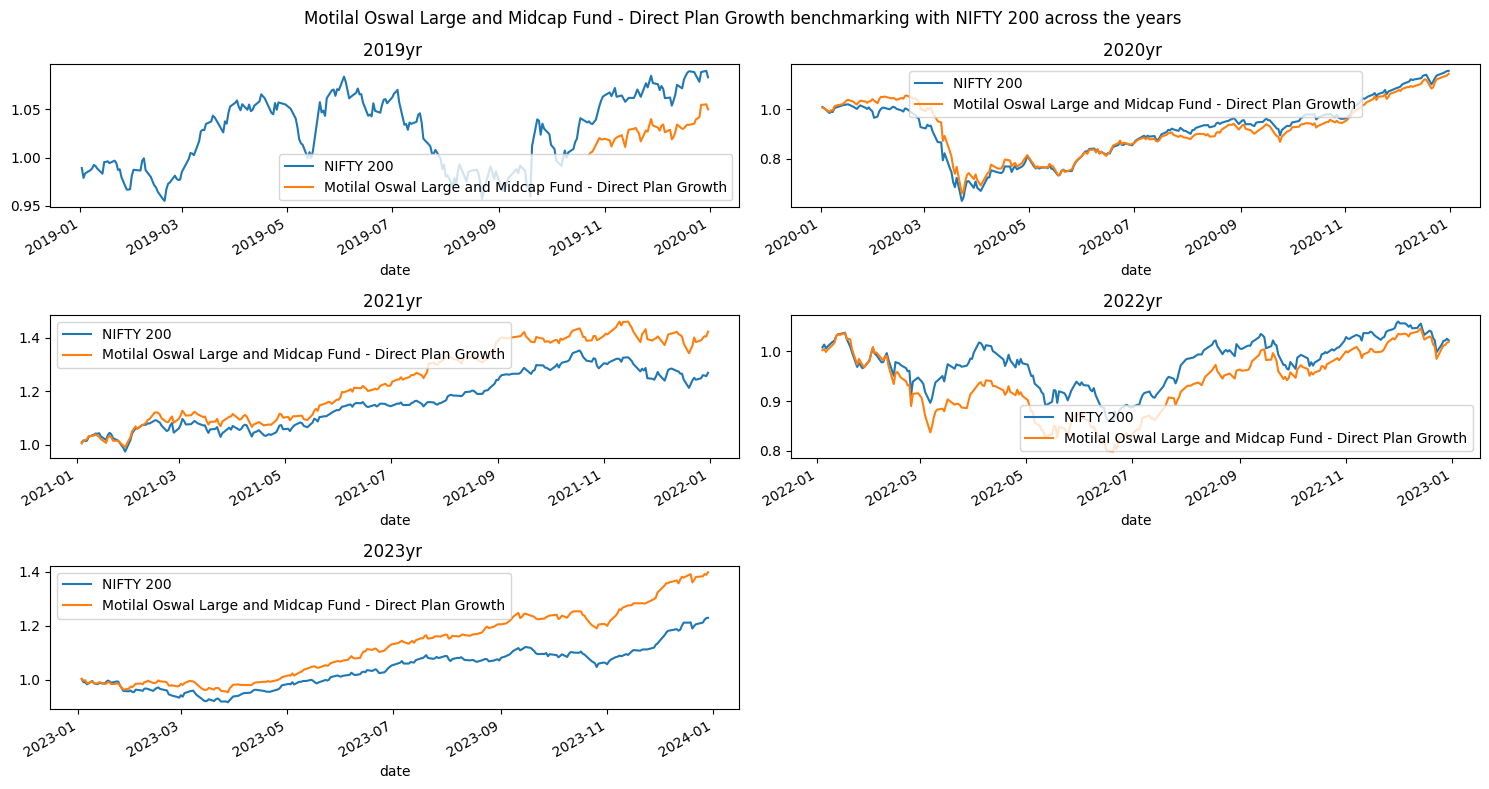

In [16]:
for fund, index in funds_benchmark_mapping.items():
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()
    for ax in axes:
        ax.set_axis_off()

    for i, time_period in enumerate(sorted(list(time_periods))):
        index_df = time_period_nifty_dataframes[time_period][index].copy()
        fund_df = time_period_dataframes[time_period][fund].copy()

        # Use the current subplot
        ax = axes[i]
        ax.set_axis_on()

        # Plot on the current subplot
        index_df.plot(ax=ax, y='cumulative_daily_returns', x='date', label=index)
        fund_df.plot(ax=ax, y='cumulative_daily_returns', x='date', label=fund)

        ax.set_title(f'{time_period}yr ')

    # Adjust layout for better spacing
    plt.suptitle(f'{fund} benchmarking with {index} across the years ')
    plt.tight_layout()
    plt.show()

### Some questions: 

Analysis: Part 1 - Calculating returns for each year
1. How about each year analysis? i.e. just 2019 or just 2021. Compare fund vs benchmark 2019-01-01 to 2019-12-31, 2020-01-01 to 2020-12-31 etc
2. How many times was the fund able to beat the benchmark? 
3. WHat are one-year returns across multiple years for each fund? 
4. Has the performance of each fund increased YoY or has the performance deteriorated? 

Analysis: Part 2 - Calculating cumulative returns and CAGR 
1. Compare Fund vs benchmark at different year levels using the cumulative returns graph
2. Compare CAGR across a 3-yr period. Has the fund been able to beat the benchmark in terms of CAGR?